### Object Localization

<img src="https://blog.kakaocdn.net/dn/clMoGB/btr2PUkjYxh/InSpJZdWj5Mi7Hog4oEl1K/img.png" width="800px" />

$$
\mathbf{y} =
\begin{bmatrix}
    p_c \\
    b_x \\
    b_y \\
    b_w \\
    b_h \\
    c_1 \\
    c_2 \\
    c_3 \\
\end{bmatrix} =
\begin{bmatrix}
    \text{object existance} \\
    \text{bounding box} \\
    \text{bounding box} \\
    \text{bounding box} \\
    \text{bounding box} \\
    \text{object class} \\
    \text{object class} \\
    \text{object class} \\
\end{bmatrix}
$$

$$
\mathcal{L}(\hat{\mathbf {y}}, \mathbf{y}) =
\begin{cases}
    (\hat{\mathbf{y}} - \mathbf{y})^2, & \text{if}\ y_1=1\ (\text{object does exist}) \\
    (\hat{y}_1 - y_1)^2, & \text{if}\ y_1=0\ (\text{object does not exist})
\end{cases}
$$

cross-entropy loss for object class losses and logistic loss for object existance could be okay too.

### Landmark Detection

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*kmu_t1iNbOipwozjxCG6og.jpeg" width="200px" />

$$
\mathbf{y} =
\begin{bmatrix}
    p \\
    l_{1,x} \\
    l_{1,y} \\
    \vdots \\
    l_{64,x} \\
    l_{64,y} \\
\end{bmatrix} =
\begin{bmatrix}
    \text{object existance} \\
    \text{landmarks} \\
    \text{landmarks} \\
    \vdots \\
    \text{landmarks} \\
    \text{landmarks}
\end{bmatrix}
$$

$$
\mathcal{L}(\hat{\mathbf {y}}, \mathbf{y}) =
\begin{cases}
    (\hat{\mathbf{y}} - \mathbf{y})^2, & \text{if}\ y_1=1\ (\text{object does exist}) \\
    (\hat{y}_1 - y_1)^2, & \text{if}\ y_1=0\ (\text{object does not exist})
\end{cases}
$$

cross-entropy loss for object class losses and logistic loss for object existance could be okay too.

### Object Detection
using sliding windows! (sliding windows detection can be very costly when used with ConvNets)

Instead of flattening the last latent feature, we can use Conv2d which can be parallelized.\
There are some downsides of sliding windows algo. One is that the bounding box is inaccurate due to multiple size-reducing-layers such as Conv, Pool etc. The other is that the bounding box cannot be rectangular shaped.

torch.Size([1, 3, 28, 28])
torch.Size([1, 1, 1, 1])
tensor([[[[0.0638]]]], grad_fn=<ConvolutionBackward0>)

torch.Size([1, 3, 224, 224])
torch.Size([1, 1, 50, 50])
tensor([[[[0.0703, 0.0684, 0.0585,  ..., 0.0682, 0.0658, 0.0502],
          [0.0805, 0.0736, 0.0565,  ..., 0.0610, 0.0458, 0.0641],
          [0.0764, 0.0652, 0.0598,  ..., 0.0582, 0.0643, 0.0663],
          ...,
          [0.0736, 0.0652, 0.0703,  ..., 0.0633, 0.0642, 0.0555],
          [0.0717, 0.0602, 0.0570,  ..., 0.0587, 0.0513, 0.0572],
          [0.0708, 0.0719, 0.0611,  ..., 0.0600, 0.0570, 0.0549]]]],
       grad_fn=<ConvolutionBackward0>)


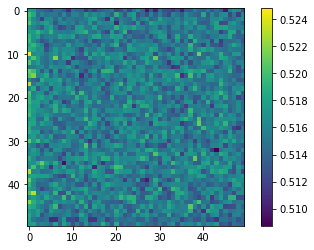

In [180]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, padding=2)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.convpool = nn.Conv2d(256, 256, kernel_size=7)
        self.fc1 = nn.Conv2d(256, 64, kernel_size=1)
        self.fc2 = nn.Conv2d(64, 1, kernel_size=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.convpool(x)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = Detector()

x = torch.randn(1,3,28,28) # sliding window size (3x28x28)
y_hat = model(x)
print(x.shape)
print(y_hat.shape)
print(y_hat)
print()

x = torch.randn(1,3,224,224) # (3x224x224) image with sliding window size (3x28x28)
y_hat = model(x)
print(x.shape)
print(y_hat.shape)
print(y_hat)

plt.imshow(y_hat.squeeze().sigmoid().detach().numpy())
plt.colorbar()
plt.show()

### YOLO algorithm

Image localization in a 19x19 grid

As the grid size decreases, the probability of having different types of objects decreases.

### Non-max suppression
- discard all boxes with $p_c \leq \text{threshold}$
- pick the box with the largest $p_c$ output that as a prediction
- discard any remaining box with $\text{IoU} \geq 0.5$ with the box output in the previous step

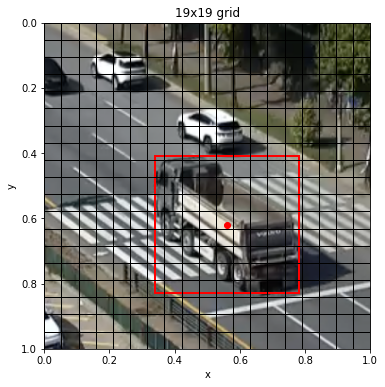

In [36]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from PIL import Image
import numpy as np

transform = T.Compose([
    T.Resize(448),
    T.CenterCrop(448),
])

img_path = Path('src') / 'dumptruck.png'
img = Image.open(img_path).convert('RGB')
img = transform(img)

fig, ax = plt.subplots(figsize=(6,6))

plt.title('19x19 grid')
ax.imshow(img, extent=[0,1,1,0])
ax.set_xlabel('x')
ax.set_ylabel('y')
for i in np.linspace(0, 1, 20):
    ax.axvline(i, lw=1, c='k')
    ax.axhline(i, lw=1, c='k')

groundtruth_point = np.array([0.56, 0.62]) # (x,y)
groundtruth_size  = np.array([0.44, 0.42]) # (w,h)

groundtruth_point - groundtruth_size/2
groundtruth_bb = patches.Rectangle(groundtruth_point-groundtruth_size/2,
                                   *groundtruth_size,
                                   linewidth=2,
                                   edgecolor='r',
                                   facecolor='none')

ax.add_patch(groundtruth_bb)
ax.scatter(*groundtruth_point, c='r')
plt.show()

$$
\text{size of Y in a single frame}= \text{rows} \times \text{cols} \times \text{maximum anchor capacity} \times ||(p_c, b_x, b_y, b_w, b_h, c_1, c_2)|| \\
$$

$$
Y_{M \times N \times (2\cdot7)} :=
\begin{bmatrix}
    p_c \\
    b_x \\
    b_y \\
    b_w \\
    b_h \\
    c_1 \\
    c_2 \\
    \hline
    p_c \\
    b_x \\
    b_y \\
    b_w \\
    b_h \\
    c_1 \\
    c_2 \\
\end{bmatrix}_{11}
\cdots
\begin{bmatrix}
    p_c \\
    b_x \\
    b_y \\
    b_w \\
    b_h \\
    c_1 \\
    c_2 \\
    \hline
    p_c \\
    b_x \\
    b_y \\
    b_w \\
    b_h \\
    c_1 \\
    c_2 \\
\end{bmatrix}_{MN}
$$

anchors can be predefined as 1:1 size, 1:2 size, 2:1 size with order for training.
$$
\begin{bmatrix}
    \text{1:1 size anchor info}\\
    \hline
    \text{2:1 size anchor info}\\
    \vdots \\
    \text{1:2 size anchor info}\\
\end{bmatrix}
$$

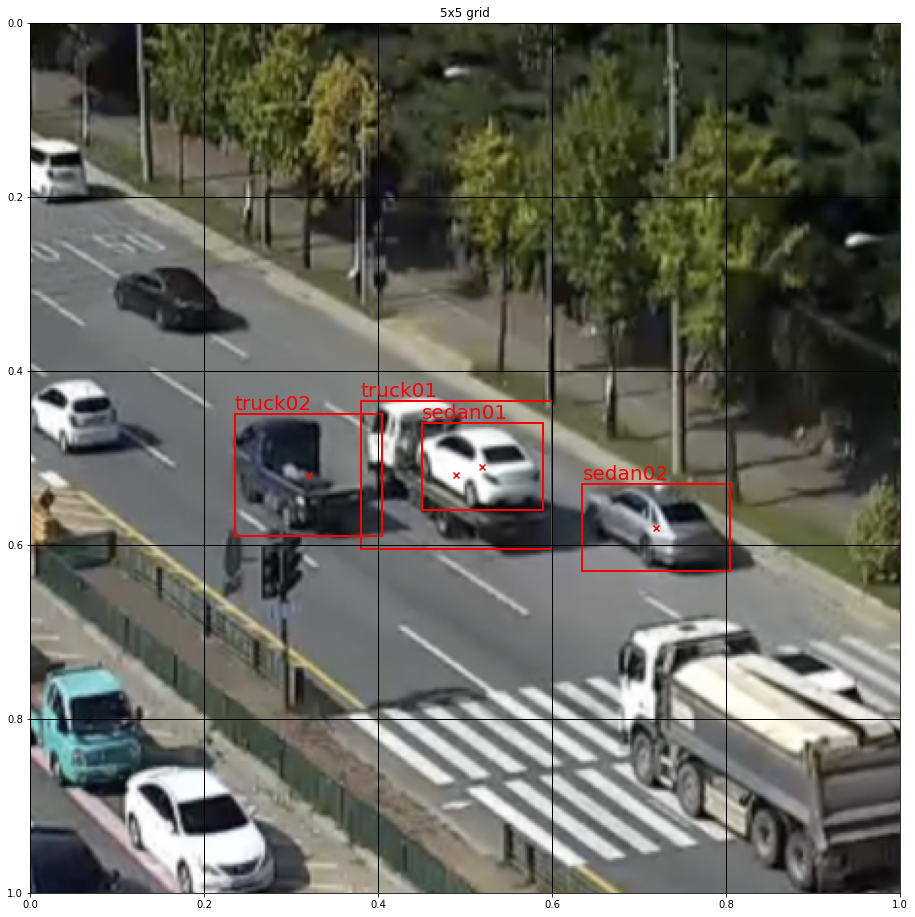

In [132]:
class AnchorBox:
    def __init__(self, label, x, y, w, h):
        self.label = label
        self.x = x
        self.y = y
        self.w = w
        self.h = h
    
    @property
    def topleft(self):
        return self.x - self.w/2, self.y - self.h/2

    @property
    def bottomright(self):
        return self.x + self.w/2, self.y + self.h/2
    
    @property
    def patch(self):
        return self.topleft, self.w, self.h

anchorboxes = [
    AnchorBox('truck01', .49, .52, .22, .17),
    AnchorBox('sedan01', .52, .51, .14, .10),
    AnchorBox('truck02', .32, .52, .17, .14),
    AnchorBox('sedan02', .72, .58, .17, .10),
]

img_path = Path('src') / 'together.png'
img = Image.open(img_path).convert('RGB')
img = transform(img)

fig, ax = plt.subplots(figsize=(16,16))
ax.set_title('5x5 grid')
ax.imshow(img, extent=[0,1,1,0])
for i in np.linspace(0, 1, 6):
    ax.axvline(i, lw=1, c='k')
    ax.axhline(i, lw=1, c='k')

for a in anchorboxes:
    patch = patches.Rectangle(*a.patch, facecolor='none', edgecolor='red', lw=2)
    ax.add_patch(patch)
    ax.annotate(a.label, a.topleft, xytext=(a.topleft[0], a.topleft[1]-0.005), fontsize=20, c='r', )
    ax.scatter(a.x, a.y, marker='x', c='r')

$$
Y =
\begin{bmatrix}
        & 1                      & 1                      & 1                      & \\
        & \dfrac{0.32-0.20}{0.20}& \dfrac{0.49-0.40}{0.20}& \dfrac{0.72-0.60}{0.20}& \\
        & \dfrac{0.52-0.40}{0.20}& \dfrac{0.52-0.40}{0.20}& \dfrac{0.58-0.40}{0.20}& \\
        & \dfrac{0.17}{0.20}     & \dfrac{0.22}{0.20}     & \dfrac{0.17}{0.20}     & \\
        & \dfrac{0.14}{0.20}     & \dfrac{0.17}{0.20}     & \dfrac{0.10}{0.20}     & \\
        & 0                      & 1                      & 1                      & \\
        & 1                      & 0                      & 0                      & \\
        \hline
        & 0                      & 1                      & 0                      & \\
        & \cdot                  & \dfrac{0.52-0.40}{0.20}& \cdot                  & \\
        & \cdot                  & \dfrac{0.51-0.40}{0.20}& \cdot                  & \\
        & \cdot                  & \dfrac{0.14}{0.20}     & \cdot                  & \\
        & \cdot                  & \dfrac{0.10}{0.20}     & \cdot                  & \\
        & \cdot                  & 1                      & \cdot                  & \\
        & \cdot                  & 0                      & \cdot                  & \\
\end{bmatrix}
$$

### U-Net

semantic segmentation using transpose convolutions

<img src="https://cdn-images-1.medium.com/max/850/1*f6Uhb8MI4REGcYKkYM9OUQ.png" width="400px" />

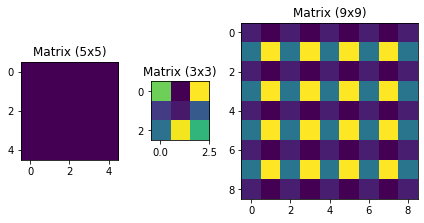

In [210]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

x = torch.ones(1, 1, 5, 5)
convt2d = nn.ConvTranspose2d(
    in_channels=1, 
    out_channels=1, 
    kernel_size=3, 
    stride=2, 
    padding=1, 
    bias=False
)

fig = plt.figure(figsize=(6,6))

matrices_data = [
    x.squeeze().numpy(),
    convt2d.weight.detach().squeeze().numpy(),
    convt2d(x).detach().squeeze().numpy()
]

widths = [matrix.shape[1] for matrix in matrices_data]
gs = gridspec.GridSpec(1, 3, width_ratios=widths)

axes = [fig.add_subplot(gs[i]) for i in range(3)]

for matrix, ax in zip(matrices_data, axes):
    ax.imshow(matrix)
    ax.set_title(f"Matrix ({matrix.shape[0]}x{matrix.shape[1]})")

plt.tight_layout()
plt.show()


In [ ]:
import torchvision

torchvision.ops.